<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# Transfer Learning in Computer Vision
Rather than creating our own model from scratch, we can use models which have been pre-trained on other generic tasks to take advantage of the training that has already occurred.  When we do this, we usually keep the model parameters fixed except for the last layer.  We use a new last layer (a fully connected Linear layer) which we then train on our specific task.  One way to think about this approach is that the pre-trained layers act as "feature detectors" which identify feature patterns within the images.  These features are then fed into the final fully-connected layer which attempts to classify the image based on the input features it receives from the rest of the model.

Most commonly we use models which have been pre-treained on the ImageNet dataset.  All models pre-trained on ImageNet expect input images to be normalized in the same way, i.e. mini-batches of 3-channel RGB images with each image having shape (3 x H x W), where H and W are expected to be at least 224 pixels. The pixel values should be first scaled to a range of [0, 1] (accomplished by using `transforms.ToTensor()`) and then normalized using the mean and standard deviation of image pixel values across the image dataset.  Since it can be difficult to calculate these statistics, we often just normalize by the mean and standard deviation of the ImageNet images, which are mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. You can use the following transform to normalize: `normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])`

The model we will be using is a ResNet18 model pre-trained on ImageNet.

**Notes:**
- This notebook should be run on GPU, although the first part can run on CPU in 10-15 minutes

**References:**
- This notebook includes example code adapted from the [PyTorch docs](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
- This example uses a ResNet18 architecture pre-trained on ImageNet.  Read the original [ResNet paper](https://arxiv.org/pdf/1512.03385.pdf)


In [ ]:
# Run this cell only if working in Colab
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "AIPI540-Deep-Learning-Applications" # Enter repo name
git_path = 'https://github.com/AIPI540/AIPI540-Deep-Learning-Applications.git'
!git clone "{git_path}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}"

# Change working directory to location of notebook
notebook_dir = '2_computer_vision/CNNs'
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls

In [2]:
import os
import urllib.request
import zipfile
import copy
import time
import numpy as np
import pandas as pd
import torch
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import FashionMNIST
from torchsummary import summary

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

torch:  1.10 ; cuda:  1.10.1


## Transfer Learning Example
In this example we will create a classifier capable distinguishing between images of ants and bees.  We will use a ResNet18 model which has been pre-trained on ImageNet and we will conduct fine-tuning training for our specific task.

In [3]:
# Download the data
if not os.path.exists('./data'):
    os.mkdir('./data')
if not os.path.exists('data/hymenoptera_data'):
    url = 'https://download.pytorch.org/tutorial/hymenoptera_data.zip'
    urllib.request.urlretrieve(url,filename='data/hymenoptera_data.zip')
    zip_ref = zipfile.ZipFile('data/hymenoptera_data.zip', 'r')
    zip_ref.extractall('data/')
    zip_ref.close()

### Set up dataloaders for our data
We will first create and apply a pipeline of transformations to apply to our images before feeding them into the model.  We apply data augmentation techniques such as random cropping and random horizontal flipping to our training data to make our model more robust to different layouts of objects in images.  We apply normalization to both the training and validation (test) sets.  Since we are using a model pre-trained on ImageNet, our model expects input images to be normalized in the same way, i.e. mini-batches of 3-channel RGB images each having shape (3 x H x W), where H and W are expected to be at least 224 pixels. The pixel values should be first scaled to a range of [0, 1] (accomplished by using `transforms.ToTensor()`) and then normalized using the mean and standard deviation of image pixel values across the image dataset.  Since it can be difficult to calculate these statistics, we will just normalize by the mean and standard deviation of the ImageNet images, which are mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

In [4]:
data_dir = 'data/hymenoptera_data'

# Set up transformations for training and validation (test) data
# For training data we will do randomized cropping to get to 224 * 224, randomized horizontal flipping, and normalization
# For test set we will do only center cropping to get to 224 * 224 and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create Datasets for training and validation sets
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                          data_transforms['train'])
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'),
                                          data_transforms['val'])

# Create DataLoaders for training and validation sets
batch_size = 4
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                             shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)

# Set up dict for dataloaders
dataloaders = {'train':train_loader,'val':val_loader}

# Store size of training and validation sets
dataset_sizes = {'train':len(train_dataset),'val':len(val_dataset)}
# Get class names associated with labels
class_names = train_dataset.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.Size([4, 3, 224, 224])


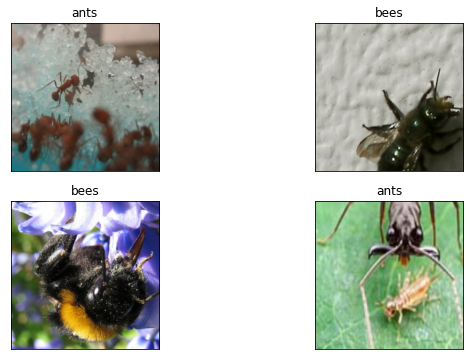

In [5]:
# Visualize a batch of images
images, labels = iter(train_loader).next()
print(images.shape)
images = images.numpy()
fig = plt.figure(figsize=(10, 6))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size//2, idx+1, xticks=[], yticks=[])
    image = images[idx]
    image = image.transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    ax.imshow(image)
    ax.set_title("{}".format(class_names[labels[idx]]))

As we see above, the inputs in a PyTorch DataLoader are of shape [N,C,H,W) where:  
- N = batch size  
- C = number of channels (1 for grayscale, 3 for RGB color)  
- H = image height  
- W = image width

### Define our model architecture
We will used a pre-trained ResNet18 model, so our architecture has already been defined.  The cell below loads the ResNet18 pre-trained model, freezes the model layers so that they are not trained during training (we will only train a final new layer which we will add on), and displays a summary of the model layers and the output shape of the input, a (3,224,224) image, after passing through each layer.

In [6]:
# Instantiate pre-trained resnet
net = torchvision.models.resnet18(pretrained=True)
# Shut off autograd for all layers to freeze model so the layer weights are not trained
for param in net.parameters():
    param.requires_grad = False

# Display a summary of the layers of the model and output shape after each layer
summary(net,(images.shape[1:]),batch_size=batch_size,device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [4, 64, 112, 112]           9,408
       BatchNorm2d-2          [4, 64, 112, 112]             128
              ReLU-3          [4, 64, 112, 112]               0
         MaxPool2d-4            [4, 64, 56, 56]               0
            Conv2d-5            [4, 64, 56, 56]          36,864
       BatchNorm2d-6            [4, 64, 56, 56]             128
              ReLU-7            [4, 64, 56, 56]               0
            Conv2d-8            [4, 64, 56, 56]          36,864
       BatchNorm2d-9            [4, 64, 56, 56]             128
             ReLU-10            [4, 64, 56, 56]               0
       BasicBlock-11            [4, 64, 56, 56]               0
           Conv2d-12            [4, 64, 56, 56]          36,864
      BatchNorm2d-13            [4, 64, 56, 56]             128
             ReLU-14            [4, 64,

Since we only have 2 output classes rather than the 1000 in ImageNet, we will replace the ResNet's final layer with a new fully connected Linear layer which we will train on our specific task.  This layer acts as a multiclass classifier, using the feature patterns identified by the previous convolutional layers to predict the output class.  When we train our model, this is the only layer that we will train.

In [7]:
# Get the number of inputs to final Linear layer
num_ftrs = net.fc.in_features
# Replace final Linear layer with a new Linear with the same number of inputs but just 2 outputs,
# since we have 2 classes - bees and ants
net.fc = nn.Linear(num_ftrs, 2)

### Define cost function and optimizer
We will use Cross Entropy as the cost/loss function and SGD for the optimizer.

In [8]:
# Cross entropy loss combines softmax and nn.NLLLoss() in one single class.
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Train the model

In [9]:
def train_model(model, criterion, optimizer, dataloaders, scheduler, device, num_epochs=25):
    model = model.to(device) # Send model to GPU if available
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Get the input images and labels, and send to GPU if available
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the weight gradients
                optimizer.zero_grad()

                # Forward pass to get outputs and calculate loss
                # Track gradient only for training data
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backpropagation to get the gradients with respect to each weight
                    # Only if in train
                    if phase == 'train':
                        loss.backward()
                        # Update the weights
                        optimizer.step()

                # Convert loss into a scalar and add it to running_loss
                running_loss += loss.item() * inputs.size(0)
                # Track number of correct predictions
                running_corrects += torch.sum(preds == labels.data)

            # Step along learning rate scheduler when in train
            if phase == 'train':
                scheduler.step()

            # Calculate and display average loss and accuracy for the epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # If model performs better on val set, save weights as the best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:3f}'.format(best_acc))

    # Load the weights from best model
    model.load_state_dict(best_model_wts)

    return model

In [10]:
# Learning rate scheduler - decay LR by a factor of 0.1 every 7 epochs
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Train the model
net = train_model(net, criterion, optimizer, dataloaders, lr_scheduler, device, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.5908 Acc: 0.6516
val Loss: 0.2377 Acc: 0.9281

Epoch 1/9
----------
train Loss: 0.6336 Acc: 0.7295
val Loss: 0.2221 Acc: 0.9281

Epoch 2/9
----------
train Loss: 0.4235 Acc: 0.8156
val Loss: 0.2568 Acc: 0.9281

Epoch 3/9
----------
train Loss: 0.6160 Acc: 0.7295
val Loss: 0.2122 Acc: 0.9216

Epoch 4/9
----------
train Loss: 0.4162 Acc: 0.8156
val Loss: 0.2077 Acc: 0.9346

Epoch 5/9
----------
train Loss: 0.4677 Acc: 0.8402
val Loss: 0.2128 Acc: 0.9346

Epoch 6/9
----------
train Loss: 0.4942 Acc: 0.7869
val Loss: 0.3883 Acc: 0.8497

Epoch 7/9
----------
train Loss: 0.4183 Acc: 0.8197
val Loss: 0.2157 Acc: 0.9412

Epoch 8/9
----------
train Loss: 0.3427 Acc: 0.8566
val Loss: 0.2503 Acc: 0.9281

Epoch 9/9
----------
train Loss: 0.3864 Acc: 0.8484
val Loss: 0.2397 Acc: 0.9412

Training complete in 7m 53s
Best val Acc: 0.941176


### Visualize results

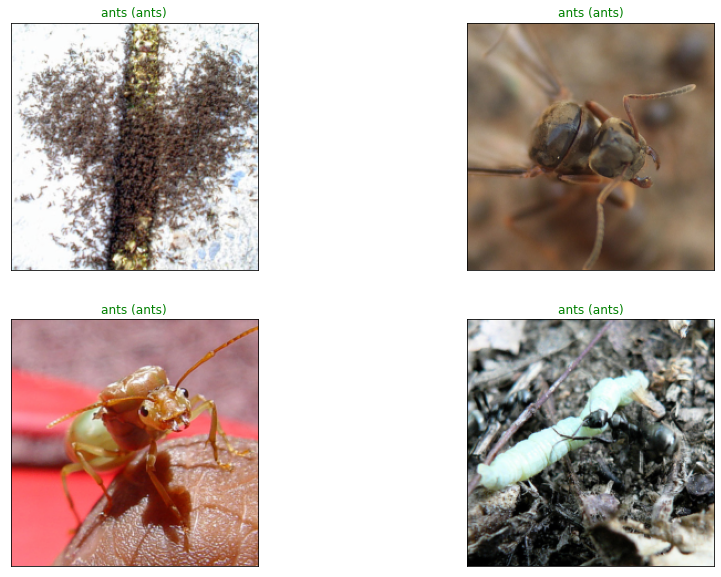

In [11]:
# Display a batch of predictions
def visualize_results(model,dataloader,device):
    model = model.to(device) # Send model to GPU if available
    with torch.no_grad():
        model.eval()
        # Get a batch of validation images
        images, labels = iter(val_loader).next()
        images, labels = images.to(device), labels.to(device)
        # Get predictions
        _,preds = torch.max(model(images), 1)
        preds = np.squeeze(preds.cpu().numpy())
        images = images.cpu().numpy()

    # Plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(15, 10))
    for idx in np.arange(len(preds)):
        ax = fig.add_subplot(2, len(preds)//2, idx+1, xticks=[], yticks=[])
        image = images[idx]
        image = image.transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        ax.imshow(image)
        ax.set_title("{} ({})".format(class_names[preds[idx]], class_names[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx] else "red"))
    return

visualize_results(net,val_loader,device)

## Transfer Learning on FashionMNIST
In this example we will load a ResNet18 model and use it on the FashionMNIST dataset. The FashionMNIST dataset has a couple of differences relative to the ImageNet dataset on which pretrained models are trained:  
- It is grayscale so has only 1 channel instead of 3. 
- It is 28 * 28 rather than 224 * 224. 
- The mean and standard deviation of pixel values across the FashionMNIST dataset are quite different from the images in ImageNet  
- We have only 10 classes as output rather than 1000 as in ImageNet

Because of those differences, we need to make two adjustments to use our pretrained model:  
1) We need to transform our input image data to be 224*224 and normalize using the images mean and standard deviation  (NOT the ImageNet mean and std in this case since they are very different)
2) We need to change our net architecture to accomodate 1 input channel (grayscale, rather than the usual 3 for RGB), and 10 output classes

In [ ]:
# We need to add a transformation to our input image data
# Resnet18 expects input images of shape 224*224
# We also should normalize our pixel values by subracting mean and dividing by standard deviation of training set values

if not os.path.exists('./data'):
    os.mkdir('./data')

train_data = FashionMNIST(root='data', train=True, download=True)

data_transform = transforms.Compose([ transforms.Resize((224, 224)),
                                         transforms.ToTensor(), 
                                         transforms.Normalize((train_data.data.float().mean()/255), (train_data.data.float().std()/255))])

train_data_resnet = FashionMNIST(root='data', train=True,
                                   download=True, transform=data_transform)

test_data_resnet = FashionMNIST(root='data', train=False,
                                  download=True, transform=data_transform)

batch_size = 16
train_loader_resnet = DataLoader(train_data_resnet,batch_size=batch_size, shuffle=True)
test_loader_resnet = DataLoader(test_data_resnet,batch_size=batch_size, shuffle=False)

# Specify the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Set random seeds for reproducibility
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)

In [ ]:
def train_model(model,criterion,optimizer,train_loader,n_epochs,device):
    
    loss_over_time = [] # to track the loss as the network trains
    
    model = model.to(device) # Send model to GPU if available
    model.train() # Set the model to training mode
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        
        for i, data in enumerate(train_loader):
            
            # Get the input images and labels, and send to GPU if available
            inputs, labels = data[0].to(device), data[1].to(device)

            # Zero the weight gradients
            optimizer.zero_grad()

            # Forward pass to get outputs
            outputs = model(inputs)

            # Calculate the loss
            loss = criterion(outputs, labels)

            # Backpropagation to get the gradients with respect to each weight
            loss.backward()

            # Update the weights
            optimizer.step()

            # Convert loss into a scalar and add it to running_loss
            running_loss += loss.item()
            
            if i % 1000 == 999:    # print every 1000 batches
                avg_loss = running_loss/1000
                # record and print the avg loss over the 1000 batches
                loss_over_time.append(avg_loss)
                print('Epoch: {}, Batch: {}, Avg. Loss: {:.4f}'.format(epoch + 1, i+1, avg_loss))
                running_loss = 0.0

    return loss_over_time

In [ ]:
def test_model(model,test_loader,device):
    model = model.to(device)
    # Turn autograd off
    with torch.no_grad():

        # Set the model to evaluation mode
        model.eval()

        # Set up lists to store true and predicted values
        y_true = []
        test_preds = []

        # Calculate the predictions on the test set and add to list
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            # Feed inputs through model to get raw scores
            logits = model.forward(inputs)
            # Convert raw scores to probabilities (not necessary since we just care about discrete probs in this case)
            probs = F.softmax(logits,dim=1)
            # Get discrete predictions using argmax
            preds = np.argmax(probs.cpu().numpy(),axis=1)
            # Add predictions and actuals to lists
            test_preds.extend(preds)
            y_true.extend(labels.cpu())

        # Calculate the accuracy
        test_preds = np.array(test_preds)
        y_true = np.array(y_true)
        test_acc = np.sum(test_preds == y_true)/y_true.shape[0]
        
        # Recall for each class
        recall_vals = []
        for i in range(10):
            class_idx = np.argwhere(y_true==i)
            total = len(class_idx)
            correct = np.sum(test_preds[class_idx]==i)
            recall = correct / total
            recall_vals.append(recall)
    
    return test_acc,recall_vals

In [ ]:
# Load a resnet18 pre-trained model
model_resnet = torchvision.models.resnet18(pretrained=True)
# Shut off autograd for all layers to freeze model so the layer weights are not trained
for param in model_resnet.parameters():
    param.requires_grad = False
    
# Replace the resnet input layer to take in grayscale images (1 input channel), since it was trained on color (3 input channels)
in_channels = 1
model_resnet.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Replace the resnet final layer with a new fully connected Linear layer we will train on our task
# Number of out units is number of classes (10)
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, 10)

# Train the model
n_epochs = 3
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_resnet.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cost_path = train_model(model_resnet,criterion,optimizer,train_loader_resnet,n_epochs,device)

# Visualize the loss as the network trained
plt.plot(cost_path)
plt.xlabel('Batch (1000s)')
plt.ylabel('loss')
plt.show()

In [ ]:
# Test the pre-trained model
acc,recall_vals = test_model(model_resnet,test_loader_resnet,device)
print('Test set accuracy is {:.3f}'.format(acc))
for i in range(10):
    print('For class {}, recall is {}'.format(classes[i],recall_vals[i]))